Нейросетка для поиска ключевого слова в аудиофайле.



































Меняя параметры/гиперпараметры модели и подход к формированию выборки,
добейтесь максимальной точности сетки. Добейтесь такой точности сети, чтобы в предикте всех кусочков файла text_with_cond3.wav везде были значения 3 и только в одном месте последовательность 0. Выглядит это примерно вот так:

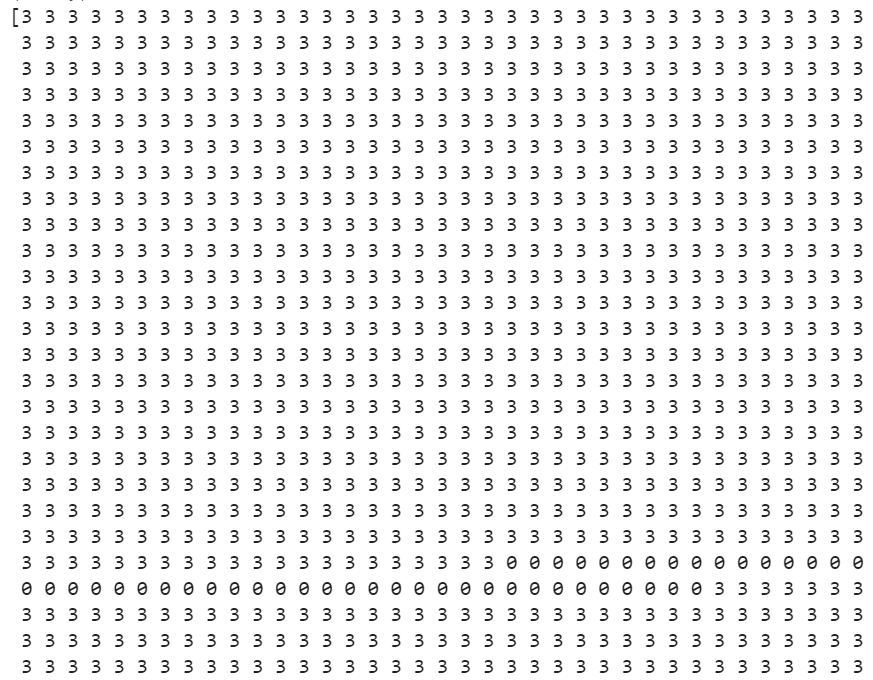


In [ ]:
# Ваше решение

In [ ]:
%%capture

# Установка librosa 0.7 (для использованя функции librosa.features.inverse.mfcc_to_audio)
!pip install git+https://github.com/librosa/librosa 

In [ ]:
# Библиотека для работы с массивами данных
import numpy as np 

# Интерфейс для построения графиков простых функций
from matplotlib import pyplot as plt 

# Загружаем модуль чтобы обратиться к HTML для записи аудио с микрофона в ноутбуке
from IPython.display import Audio 

# Библиотека для параметризации аудио
import librosa 

# Модуль для работы с каталогами 
import os 

# Модуль для разбивки данных на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split 

# Загружаем утилиты кераса для one hot кодировки
from tensorflow.keras.utils import to_categorical 

# Быстрый и удобный progress bar для Python
from tqdm import tqdm 

# Загружаем алгоритмы обучения/оптимизации
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta 

# Последовательная модель нейросети кераса
from tensorflow.keras.models import Sequential 

# Загружаем необходимые слои для нейросети
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Reshape 

# Библиотека для воспроизведения звуковых файлов
import IPython.display as ipd

# Загрузка датасетов из облака google
import gdown

In [ ]:
# Данные для обучения
url = 'https://storage.googleapis.com/datasets_ai/Advanced/15_audio/data.zip'
gdown.download(url, None, quiet=False)

# Данные для теста
url = 'https://storage.googleapis.com/datasets_ai/Advanced/15_audio/test.zip'
gdown.download(url, None, quiet=False)

Downloading...
From: https://storage.googleapis.com/datasets_ai/Advanced/15_audio/data.zip
To: /content/data.zip
100%|██████████| 130M/130M [00:01<00:00, 98.2MB/s]
Downloading...
From: https://storage.googleapis.com/datasets_ai/Advanced/15_audio/test.zip
To: /content/test.zip
100%|██████████| 107M/107M [00:01<00:00, 102MB/s]


'test.zip'

In [ ]:
# Разархивируем обучающие данные
!unzip -q '/content/data.zip' -d /content/data

# Разархивируем тестовые данные
!unzip -q '/content/test.zip' -d /content/test

In [ ]:
# Зададим путь к папке с аудиофайлами
DATA_PATH = "/content/data/" 

# Зададим пусть к файлу с тестовыми 30-тисекнудными аудиофайлами
DATA_PATH_TEST = "/content/test/"

In [ ]:
sample_rate = 22050                   # Значение sample_rate аудиофайлов
feature_dim_1 = 20                    # Стандартная величина MFCC признаков
feature_dim_2 = int(.7 * sample_rate) # Длина фреймов (в секундах 0.5 = 500 мс)
step_mfcc = int(.02 * sample_rate)    # Шаг смещения (в секундах 0.1 = 100мс)
channel = 1                           # Количество каналов
n_classes = 4                         # Количество классов команд (4-ый класс - шум)

classes = ['КОНДИЦИОНЕР',             # Классы команд (без шума)
           'СВЕТ',
           'ТЕЛЕВИЗОР'] 

In [ ]:
def get_labels(path=DATA_PATH): 
  
  '''
  Функция извлечения лейблов классов и их обработки

  Args:
    path - путь к папке, в которой находятся каталоги с обучающими командами 

  Returns:
    labels - имена лейблов, str
    label_indices - индексы лейблов, int
    to_categorical(label_indices) - ohe лейблов
  '''
  
  # Запишем лейблы классов по названию папок - ['кондиционер', 'телевизор', 'свет', 'фон']  
  labels = sorted(os.listdir(path)) 
  
  # Запишем лейблы в виде индексов - [0, 1, 2, 3]
  label_indices = np.arange(0, len(labels)) 
  
  # Функция вернёт лейблы, индексы лейблов и их one-hot представление[0, 1, 0, 0]
  return labels, label_indices, to_categorical(label_indices) 

In [ ]:
# Выведем имена лейблов
l,_,_ = get_labels()
l

['1_cond', '2_light', '3_tv', '4_noise']

In [ ]:
def wav2mfcc(file_path, 
             length = 11025, 
             step = 2205): 
  '''
  Функция параметризации аудио(wav в мел-частоты)

  Args:
    file_path - путь к аудио файлу
    length - длинна отрезков, на которые разбиваем исходный файл, int
    step - шаг, на который смещаем разбиение отрезка, int

  Returns:
    out_mfcc - массив мел-частот
    out_audio - массив аудио-отрезков
  '''
  
  # Выходной массив, содержащий mfcc исходного файла с шагом step
  out_mfcc = []  

  # Выходной массив, содержащий аудиоинформацию исходного файла с шагом step
  out_audio = []                  
  
  # Загружаем данные исходного файла
  y, sr = librosa.load(file_path)   
  #print("y",y.shape,sr)
  # Проходим весь массив y, пока оставшийся кусочек не станет меньше указанной в параметре max_len длинны
  while (len(y)>=length):                              
    
    # Берем начальный кусок длинной length
    section = y[:length]
    # Переводим в numpy
    section = np.array(section) 
    #print(section.shape)
    # Добавляем в выходной массив out_mfcc значение mfcc текущего куска
    out_mfcc.append(librosa.feature.mfcc(section, sr))
    #print(out_mfcc[-1].shape)
    # Добавляем в выходной массив аудио текущий кусок
    out_audio.append(section)      
    # Уменьшаем y на step
    y = y[step:]                                       
    
  # Преобразуем в numpy
  out_mfcc = np.array(out_mfcc)    
  
  # Преобразуем в numpy
  out_audio = np.array(out_audio)  
  #print(out_mfcc.shape)
  #print(out_audio.shape)
  
  # Функция вернет массив мел-частот и массив аудио-отрезков
  return out_mfcc, out_audio       

In [ ]:
def save_data_to_array(path=DATA_PATH, 
                       length=11025):
  '''
  Функция формирования и сохранения векторов данных, 
  полученных для каждого набора аудио-команд в датасете

  Args:
    path - путь к папке, в которой находятся каталоги с обучающими командами    
    length - длинна отрезков, на которые разбиваем исходный файл

  Returns:
    
  '''

  # Извлекаем лейблы классов
  labels, _, _ = get_labels(path) 
  
  # Проходим циклом по каждому лейблу
  for label in labels:            
    
    # Собираем векторы MFCC частот
    mfcc_vectors = []            
    # Извлечем для каждого файла его путь c названием папки и именем файла и соберём в список
    wavfiles = [path + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]

    # Для каждого файла
    for wavfile in tqdm(wavfiles, "Сохраняем векторы класса - '{}'".format(label)): 
      # Получим мел-частоты
      mfcc, _ = wav2mfcc(wavfile, length=length, step = step_mfcc)       
      
      # Если массив не нулевой длинны
      if (mfcc.shape[0] != 0 ):           
        # Добавим вектор в список для соответствующего класса
        mfcc_vectors.extend(mfcc)         
    
    # Сохраним массивы данных для каждого класса
    np.save(label + '.npy', mfcc_vectors) 

In [ ]:
def get_train_test(split_ratio=0.7, 
                   random_state=42, 
                   colab = True):
  '''
  Функция для получения обучающей/проверочной выборки

  Args:
    split_ratio - (1-split_ratio) равно доле тестовых образцов, которые вернет функция train_test_split, float [0..1]
    random_state - начальное число, используемое генератором случайных чисел в финкции train_test_split, int
    colab - запускаем код в колабе или нет, bool

  Returns:
    4 массива обучающих и проверочных данных
  '''

  labels, indices, _ = get_labels(DATA_PATH)  # Извлекаем имена и индексы лейблов классов
  X = np.load('/content/'+labels[0] + '.npy') # Берем набор векторов для первого класса 
  y = np.zeros(X.shape[0], dtype = 'int32')   # Устанавливаем размер соответствующего ему лейбла

  # Объединяем в единый датасет в виде np-массива обучающий и проверочный набор данных
  for i, label in enumerate(labels[1:]): 
    
    # Условие, если запускаем а колабе
    if colab:                                 
      # Читаем очередной массив данных
      x = np.load(label + '.npy')              
    else:                                     
      # Читаем очередной массив данных
      x = np.load('/content/'+label + '.npy')  
    
    # Соединяем с исходным набором
    X = np.vstack((X, x))                     
    
    # В массив y добавлем x.shape[0]-элеменентов со значением (i + 1)
    y = np.append(y, np.full(x.shape[0], fill_value= (i + 1))) 
  
  # Разделяем данные на обучающую и проверочную выборки
  return train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True) 

In [ ]:
# Формируем и сохраняем векторы данных, полученных для каждого набора аудио-команд в датасете
# ВНИМАНИЕ! Ячейка будет обрабатывать файлы около 8 минут

save_data_to_array(length=feature_dim_2)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: Pass y=[-4.1631561e-02 -3.7489176e-02 -3.1899504e-02 ... -8.8541146e-06
 -3.1806165e-05 -8.0492804e-08], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: Pass y=[ 9.7960131e-03  1.1720859e-02  1.2540268e-02 ... -3.0189211e-05
 -3.2811109e-05 -2.5325618e-05], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: Pass y=[-5.1984340e-03 -3.9061110e-03 -3.8182687e-03 ...  2.8974546e-06
 -4.3770568e-05 -6.3647545e-05], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarni

In [ ]:
# Формируем обучающую и проверочную выборки

x_train, x_test, y_train, y_test = get_train_test(colab=False)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(53741, 20, 31) (53741,)
(23033, 20, 31) (23033,)


In [ ]:
# Добавляем ещё одну размерность в конце 'x' выборок, для использования сверток

x_train = x_train[..., None]
x_test = x_test[..., None]

# Представляем лейблы классов обучающего и проверочного набора в виде one-hot вектора ((0, 1, 0) и т.п)

y_train_hot = to_categorical(y_train) 
y_test_hot = to_categorical(y_test)   

In [ ]:
# Выведем размерность x_train
x_train.shape

(53741, 20, 31, 1)

In [ ]:
# Посмотрим сколько примеров имеет класс шум

idx = np.where(y_train==3)
idx[0].shape

(50447,)

In [ ]:
# Объявим функцию создания модели нейросети

def get_model():

  model = Sequential()
  model.add(Conv2D(8, kernel_size=(3, 3), activation='relu', input_shape=(x_train.shape[1], x_train.shape[2], channel)))
  model.add(MaxPooling2D(pool_size=(2, 2))) # Передаём на слой подвыборки, снижающий размерность поступивших на него данных 
  model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding='valid'))
  #model.add(MaxPooling2D(pool_size=(2, 2))) # Передаём на слой подвыборки, снижающий размерность поступивших на него данных 
  model.add(Conv2D(25, kernel_size=(3, 3), activation='relu', padding='valid'))
  #model.add(BatchNormalization())           # Пропускаем через слой нормализации данных
  model.add(Conv2D(48, kernel_size=(3, 3), activation='relu', padding='valid'))
  model.add(Conv2D(120, kernel_size=(3, 3), activation='relu', padding='valid'))
  #model.add(MaxPooling2D(pool_size=(2, 2))) # Передаём на слой подвыборки, снижающий размерность поступивших на него данных 
  model.add(BatchNormalization())           # Пропускаем через слой нормализации данных
  model.add(Flatten())                      # Сплющиваем в одномерный вектор  
  model.add(Dense(128, activation='relu'))  # Добавляем полносвязный слой размером в заданное кол-во нейронов
  model.add(Dropout(0.25))                  # Добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
  model.add(BatchNormalization())           # Пропускаем через слой нормализации данных
  model.add(Dense(n_classes, activation='softmax')) # Добавляем полносвязный слой с функцией активации softmax на выходном слое для 4 классов
  
  # Компилируем, составляем модель с алгоритмом оптимизации, функцией потерь и метрикой точности
  model.compile(loss='categorical_crossentropy',
                optimizer=Adam(0.001),
                metrics=['accuracy'])       
  
  return model

In [ ]:
# Объявим функцию создания модели нейросети

def get_model():

  model = Sequential()
  model.add(Conv2D(6, kernel_size=(3, 3), activation='relu', input_shape=(x_train.shape[1], x_train.shape[2], channel)))
  model.add(MaxPooling2D(pool_size=(2, 2))) # Передаём на слой подвыборки, снижающий размерность поступивших на него данных 
  model.add(Conv2D(12, kernel_size=(3, 3), activation='relu', padding='valid'))
  model.add(Dropout(0.2))                  # Добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
  #model.add(MaxPooling2D(pool_size=(2, 2))) # Передаём на слой подвыборки, снижающий размерность поступивших на него данных 
  model.add(Conv2D(19, kernel_size=(3, 3), activation='relu', padding='valid'))
  #model.add(BatchNormalization())           # Пропускаем через слой нормализации данных
  model.add(Conv2D(30, kernel_size=(3, 3), activation='relu', padding='valid'))
  model.add(Dropout(0.2))                  # Добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
  model.add(Conv2D(90, kernel_size=(3, 3), activation='relu', padding='valid'))
  #model.add(MaxPooling2D(pool_size=(2, 2))) # Передаём на слой подвыборки, снижающий размерность поступивших на него данных 
  model.add(BatchNormalization())           # Пропускаем через слой нормализации данных
  model.add(Flatten())                      # Сплющиваем в одномерный вектор  
  model.add(Dense(128, activation='relu'))  # Добавляем полносвязный слой размером в заданное кол-во нейронов
  model.add(Dropout(0.25))                  # Добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
  model.add(BatchNormalization())           # Пропускаем через слой нормализации данных
  model.add(Dense(n_classes, activation='softmax')) # Добавляем полносвязный слой с функцией активации softmax на выходном слое для 4 классов
  
  # Компилируем, составляем модель с алгоритмом оптимизации, функцией потерь и метрикой точности
  model.compile(loss='categorical_crossentropy',
                optimizer=Adam(0.001),
                metrics=['accuracy'])       
  
  return model

In [ ]:
# Объявим функцию создания модели нейросети
from tensorflow.keras import regularizers
lambdaDense=0.002
lambdaConv=0.002
def get_model():

  model = Sequential()
  model.add(Conv2D(8, kernel_size=(3, 4), activation='relu',kernel_regularizer=regularizers.l2(lambdaConv),bias_regularizer=regularizers.l1(lambdaConv), input_shape=(x_train.shape[1], x_train.shape[2], channel)))
  model.add(MaxPooling2D(pool_size=(2, 2))) # Передаём на слой подвыборки, снижающий размерность поступивших на него данных 
  model.add(Conv2D(56, kernel_size=(4, 3), activation='relu',kernel_regularizer=regularizers.l2(lambdaConv),bias_regularizer=regularizers.l1(lambdaConv), padding='valid'))
  model.add(Dropout(0.2))                  # Добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
  model.add(MaxPooling2D(pool_size=(2, 2))) # Передаём на слой подвыборки, снижающий размерность поступивших на него данных 
  model.add(Conv2D(90, kernel_size=(3, 3), activation='relu',kernel_regularizer=regularizers.l2(lambdaConv),bias_regularizer=regularizers.l1(lambdaConv), padding='valid'))
  #model.add(BatchNormalization())           # Пропускаем через слой нормализации данных
  #model.add(Conv2D(48, kernel_size=(3, 3), activation='relu',kernel_regularizer=regularizers.l2(lambdaConv),bias_regularizer=regularizers.l1(lambdaConv), padding='valid'))
  #model.add(Dropout(0.2))                  # Добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
  #model.add(Conv2D(120, kernel_size=(3, 3), activation='relu',kernel_regularizer=regularizers.l2(lambdaConv),bias_regularizer=regularizers.l1(lambdaConv), padding='valid'))
  #model.add(MaxPooling2D(pool_size=(2, 2))) # Передаём на слой подвыборки, снижающий размерность поступивших на него данных 
  #model.add(BatchNormalization())           # Пропускаем через слой нормализации данных
  model.add(Flatten())                      # Сплющиваем в одномерный вектор  
  #model.add(Dropout(0.25))                  # Добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
  model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(lambdaDense),bias_regularizer=regularizers.l1(lambdaDense)))  # Добавляем полносвязный слой размером в заданное кол-во нейронов
  model.add(Dropout(0.25))                  # Добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
  model.add(BatchNormalization())           # Пропускаем через слой нормализации данных
  model.add(Dense(n_classes, activation='softmax')) # Добавляем полносвязный слой с функцией активации softmax на выходном слое для 4 классов
  
  # Компилируем, составляем модель с алгоритмом оптимизации, функцией потерь и метрикой точности
  model.compile(loss='categorical_crossentropy',
                optimizer=Adam(0.001),
                metrics=['accuracy'])       
  
  return model

In [ ]:
# Создаем модель с помощью объявленной ранее функции

model = get_model() 
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 18, 28, 8)         104       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 9, 14, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 6, 12, 56)         5432      
                                                                 
 dropout_20 (Dropout)        (None, 6, 12, 56)         0         
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 3, 6, 56)         0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 1, 4, 90)        

Epoch 1/25
27/27 [==============================] - 22s 761ms/step - loss: 1.5687 - accuracy: 0.6346 - val_loss: 0.6246 - val_accuracy: 0.9675
Epoch 2/25
27/27 [==============================] - 20s 749ms/step - loss: 0.7636 - accuracy: 0.9579 - val_loss: 0.4284 - val_accuracy: 0.9871
Epoch 3/25
27/27 [==============================] - 21s 749ms/step - loss: 0.4824 - accuracy: 0.9858 - val_loss: 0.3580 - val_accuracy: 0.9900
Epoch 4/25
27/27 [==============================] - 20s 747ms/step - loss: 0.3504 - accuracy: 0.9926 - val_loss: 0.2897 - val_accuracy: 0.9959
Epoch 5/25
27/27 [==============================] - 21s 766ms/step - loss: 0.2727 - accuracy: 0.9953 - val_loss: 0.2565 - val_accuracy: 0.9971
Epoch 6/25
27/27 [==============================] - 20s 750ms/step - loss: 0.2178 - accuracy: 0.9967 - val_loss: 0.2170 - val_accuracy: 0.9955
Epoch 7/25
27/27 [==============================] - 20s 748ms/step - loss: 0.1779 - accuracy: 0.9973 - val_loss: 0.2012 - val_accuracy: 0.9977

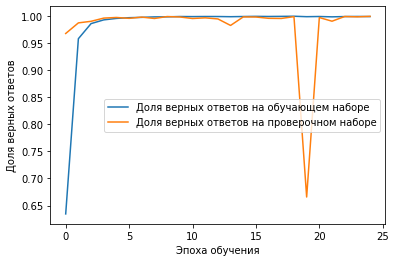

In [ ]:
# Загружаем модель данными с выбором параметров и сохраним историю обучения(ошибки/точность) для вывода графика

history = model.fit(x_train, 
                    y_train_hot, 
                    batch_size=2048, 
                    epochs=25, 
                    verbose=1, 
                    validation_data=(x_test, y_test_hot))

# Построим график, отображающий точность предсказания на обучающей и проверочной выборке

plt.plot(history.history['accuracy'], label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Проверка


Для проверки мы будем использовать аудиофайлы, в которых наговаривается текст из книги и иногда произносится одна из трех фраз "Кондиционер", "Свет", "Телевизор".

In [ ]:
# Получаем имя очередного файла
wavfiles =  DATA_PATH_TEST + 'text_with_cond3.wav' 

# Загружаем данные модулем librosa
y,sr = librosa.load(wavfiles)                      

# Выводим оригинальный аудиофайл (Команда "Кондиционер" начинается на 12 секунде)
print('Оригинальный файл:')
ipd.Audio(data=y, rate = sr) 

Оригинальный файл:


In [ ]:
# Получаем массив mfcc выбранного файла с именем namefile 
mfcc_full, audio_full = wav2mfcc(wavfiles, length=feature_dim_2, step = step_mfcc) 

# Решейпим для сверточного слоя
mfcc_full = mfcc_full.reshape(-1, 20, 31, 1)    

# Предиктим с помощью модели model массив mfcc
g_pred = model.predict(mfcc_full)    

# Выбираем индекс максимального элемента в каждом g_pred[i]  и создаем numpy-массив pred из этих индексов
pred = np.array([np.argmax(i) for i in g_pred]) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: Pass y=[-0.00057781 -0.00085932 -0.00069785 ...  0.01001257  0.03013826
  0.04226056], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: Pass y=[-0.00012648 -0.00014222 -0.00015973 ...  0.01003446  0.00879457
  0.0070657 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: Pass y=[-1.20228695e-04 -1.37508352e-04 -1.54679918e-04 ... -8.62652028e-04
 -4.37147915e-04  6.87856882e-05], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: Pass y=[-7.5836026e-05 -7.8061137e-05 -6.4911415e-05 ...  1.5081308e-02
  1.4

In [ ]:
print(g_pred.shape)

print(pred.shape)

print(pred[:1000])

(1416, 4)
(1416,)
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 